In [3]:
#data preprocessing
import numpy as np
import pyodbc
import pandas as pd

#ml stuff
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow import keras 
import tensorflow as tf
print('Tensorflow/Keras: %s' % keras.__version__)
from keras.models import Sequential 
from keras import Input 
from keras.layers import Dense
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import itertools

#utils/visualization
import time
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pickle
from ydata_profiling import ProfileReport
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

#config vars
pd.options.display.max_columns=50
pd.options.display.max_rows = 10000
verbose=1

Tensorflow/Keras: 2.12.0


# Connect to Database and get Data

In [6]:
def connect_to_db(connection_string,
                    database,
                    driver = 'SQL Server Native Client 11.0',
                    user = 'CCAdmin',
                    password = 'Miw6RjnTGmPHLYF9mG1o'
):
    connection = pyodbc.connect("Driver={"+driver+"};"
                        "Server="+connection_string+";"
                        "Database="+database+";"
                        "uid="+user+";pwd="+password+"")
    return connection

In [7]:
def get_table_data(table_name, connection):
    query = "SELECT * FROM {}".format(table_name)
    df = pd.read_sql_query(query, connection)

    return df

In [11]:
#get all tables
#cursor = connect_to_db().cursor()
#tables_list = list(cursor.tables())

#connection_string='classconprocessingger.database.windows.net'

df_table_cclogattributes = get_table_data('CCLogAttributes', connect_to_db(connection_string= 'classconprocessingger.database.windows.net', database = 'T_0001ai'))
#df_table_cclogdocuments = get_table_data('CCLogDocuments', connect_to_db(database='T_0000xu'))
#df_table_cclogdocuments.to_pickle(df_table_cclogattributes)

#df_table_cclogattributes = df_table_cclogattributes.drop('LogTime', axis=1)
df_table_cclogattributes = df_table_cclogattributes.drop(['LogTime','Zone','Attribute_DataType','LogTimeTicks'], axis=1)

df_table_cclogattributes = df_table_cclogattributes.replace('\n',' ', regex=True)
df_table_cclogattributes = df_table_cclogattributes.replace('\r',' ', regex=True)
df_table_cclogattributes.to_csv('data/cclogattributes_dvelopecm.csv', index=False, header= True, encoding='iso-8859-15')
df_table_cclogattributes


C:\Users\lete\AppData\Local\Temp\ipykernel_12944\2297382259.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


UnicodeEncodeError: 'charmap' codec can't encode character '\u2013' in position 53: character maps to <undefined>

# Data analysis


In [4]:
df = pd.read_csv('data/cclogattributes_brand_group.csv', encoding='iso-8859-15')
df.head()
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
dist = df['Delta'].value_counts()
trace = go.Pie(values=(np.array(dist)),labels=dist.index,  pull=[0, 0])
layout = go.Layout(title='Delta Distribution')
data = [trace]
fig = go.Figure(trace,layout)
fig.update_traces(marker=dict(line=dict(color='#000000', width=0.5)), textinfo='value+percent', insidetextorientation='auto')
#sfig.show()

In [6]:
dist = df['Type'].value_counts()
trace = go.Pie(values=(np.array(dist)),labels=dist.index,  pull=[0, 0.4,0.2,0.1])
layout = go.Layout(title='Type Distribution')
data = [trace]
fig = go.Figure(trace,layout)
fig.update_traces(marker=dict(line=dict(color='#000000', width=0.5)), textinfo='value+percent', insidetextorientation='auto')
#sfig.show()

In [8]:
df_ordernum = df.loc[df['Attribute_Name'] == 'OrderNum']
dist = df_ordernum['Delta'].value_counts(normalize=True)
q_ordernum = dist

print(dist)

df_documentid = df_ordernum[['DocumentID']]
documentid_list = df_documentid.values.tolist()
merged = list(itertools.chain.from_iterable(documentid_list))

df_vendor_ordernum = df.loc[(df['Attribute_Name'] == 'OrderNum')|(df['Attribute_Name'] == 'VENDOR_NUM')]
counter=0
for entry in merged:
    speicher_entry = df_vendor_ordernum[df_vendor_ordernum.DocumentID == ''.join(str(entry))]
    if (speicher_entry.Attribute_Name == 'OrderNum').any():
        if (speicher_entry.Attribute_Name == 'VENDOR_NUM').any():
            if (speicher_entry.Delta == 0).all():
                counter += 1

print(counter/246)

False    1.0
Name: Delta, dtype: float64
0.7967479674796748


# Data pre-processing


In [54]:
df = pd.read_csv('data/cclogattributes_T0012hb.csv', encoding='iso-8859-15')

vergleiche_spalten = lambda x: 'master_data_error' if x['Attribute_Name'] == 'VENDOR_NUM' and x['Attribute_Before'] != x['Attribute_After'] else'good' if x['Delta'] == False and x['Type'] == 0 else 'undefined'
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_NAME' and x['Attribute_Before'] != x['Attribute_After'] \
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_STR' and x['Attribute_Before'] != x['Attribute_After'] \
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_CITY' and x['Attribute_Before'] != x['Attribute_After'] \
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_ZIP_CODE' and x['Attribute_Before'] != x['Attribute_After'] \

df['Suggestion'] = df.apply(vergleiche_spalten, axis=1)

df = df.drop('LogTimeTicks', axis=1)
#df = df.drop('DocumentID', axis=1)

df.to_csv('data/after_preprocessing.csv', index=False, header= True, encoding='iso-8859-15')

X = df.loc[ : , df.columns != 'Suggestion']
Y = df.loc[ : , df.columns == 'Suggestion']


In [3]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

X = handle_non_numerical_data(X)


def Encoder(df):
          columnsToEncode = list(df.select_dtypes(include=['category','object','bool']))
          le = LabelEncoder()
          for feature in columnsToEncode:
              try:
                  df[feature] = le.fit_transform(df[feature])
              except:
                  print('Error encoding '+feature)
          return df


Y = Encoder(Y)
print(Y)
pd.DataFrame(Y).to_csv("data/after_numerical.csv")


print(X)
X.shape[0]
Y.shape[0]

       Suggestion
0               0
1               2
2               0
3               0
4               0
...           ...
28716           0
28717           0
28718           0
28719           0
28720           0

[28721 rows x 1 columns]
       DocumentID  Attribute_Name  Attribute_Before  Attribute_After  Delta  \
0             193               7               618              647      0   
1             193               0              3907             3579      1   
2             193              25               482              510      0   
3             193              13               482              510      0   
4             193               5              4229             4427      0   
...           ...             ...               ...              ...    ...   
28716        1504               3               355              376      0   
28717        1504              24              3722             3901      0   
28718        1504              12              

C:\Users\lete\AppData\Local\Temp\ipykernel_15024\1808292141.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = list(map(convert_to_int, df[column]))
C:\Users\lete\AppData\Local\Temp\ipykernel_15024\1808292141.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = le.fit_transform(df[feature])


28721

In [4]:
#Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=None, shuffle=False)

pd.DataFrame(y_train).to_csv("data/y_train.csv")

## Create Model and Train

In [5]:
def create_model(optimizer='adam', init='uniform'):
    # create model
    if verbose: print("**Create model with optimizer: %s; init: %s" % (optimizer, init) )
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], kernel_initializer=init, activation='relu')) #
    model.add(Dense(512, kernel_initializer=init, activation='relu'))
    model.add(Dense(256, kernel_initializer=init, activation='relu'))
    model.add(Dense(3, kernel_initializer=init, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adadelta(), metrics=['acc']) #keras.optimizers.Adadelta() and sparse_categorical_accuracy
    return model

In [46]:
run_gridsearch = False

if run_gridsearch:
    
    start_time = time.time()
    if verbose: print (time.strftime( "%H:%M:%S " + "GridSearch started ... " ) )
    optimizers = ['rmsprop'] # , 'adam'
    inits = ['glorot_uniform'] #, 'normal', 'uniform'
    epochs = [5, 50, 100, 300]
    batches = [5, 32, 64]
    
    model = KerasClassifier(build_fn=create_model, verbose=verbose)
    
    param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    if verbose: 
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
        elapsed_time = time.time() - start_time  
        print ("Time elapsed: ",timedelta(seconds=elapsed_time))
        
    best_epochs = grid_result.best_params_['epochs']
    best_batch_size = grid_result.best_params_['batch_size']
    best_init = grid_result.best_params_['init']
    best_optimizer = grid_result.best_params_['optimizer']
    
else:
    # best paramters
    best_epochs = 300
    best_batch_size = 64
    best_init = 'glorot_uniform'
    best_optimizer = 'rmsprop'

In [24]:
results_df = pd.DataFrame(grid_result.cv_results_)
pd.DataFrame(results_df).to_csv('data/grid_search_results.csv')
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
5_300_glorot_uniform_rmsprop,"{'batch_size': 5, 'epochs': 300, 'init': 'glor...",1,0.982504,0.003116
32_300_glorot_uniform_rmsprop,"{'batch_size': 32, 'epochs': 300, 'init': 'glo...",2,0.980893,0.003296
64_300_glorot_uniform_rmsprop,"{'batch_size': 64, 'epochs': 300, 'init': 'glo...",3,0.978369,0.005107
5_100_glorot_uniform_rmsprop,"{'batch_size': 5, 'epochs': 100, 'init': 'glor...",4,0.978195,0.008349
32_100_glorot_uniform_rmsprop,"{'batch_size': 32, 'epochs': 100, 'init': 'glo...",5,0.977237,0.006221
64_100_glorot_uniform_rmsprop,"{'batch_size': 64, 'epochs': 100, 'init': 'glo...",6,0.977150,0.003663
5_50_glorot_uniform_rmsprop,"{'batch_size': 5, 'epochs': 50, 'init': 'gloro...",7,0.973712,0.006883
32_50_glorot_uniform_rmsprop,"{'batch_size': 32, 'epochs': 50, 'init': 'glor...",8,0.973016,0.005055
5_5_glorot_uniform_rmsprop,"{'batch_size': 5, 'epochs': 5, 'init': 'glorot...",9,0.965486,0.009214


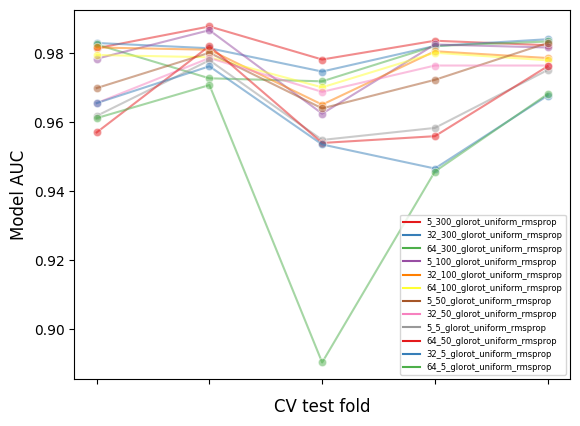

In [31]:
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
ax.legend(loc=4, prop={'size': 6})

plt.show()


In [47]:
model_pred = KerasClassifier(build_fn=create_model, optimizer=best_optimizer, init=best_init, epochs=best_epochs, batch_size=best_batch_size, verbose=verbose)
model_pred.fit(X_train, y_train)

prediction = model_pred.predict(X_test)

**Create model with optimizer: rmsprop; init: glorot_uniform
Epoch 1/300


C:\Users\lete\AppData\Local\Temp\ipykernel_15024\2894565875.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_pred = KerasClassifier(build_fn=create_model, optimizer=best_optimizer, init=best_init, epochs=best_epochs, batch_size=best_batch_size, verbose=verbose)


359/359 [==============================] - 2s 4ms/step - loss: 3.2483 - acc: 0.7972
Epoch 2/300
359/359 [==============================] - 1s 4ms/step - loss: 0.9527 - acc: 0.9364
Epoch 3/300
359/359 [==============================] - 1s 4ms/step - loss: 0.6360 - acc: 0.9523
Epoch 4/300
359/359 [==============================] - 1s 3ms/step - loss: 0.5275 - acc: 0.9583
Epoch 5/300
359/359 [==============================] - 1s 4ms/step - loss: 0.4636 - acc: 0.9603
Epoch 6/300
359/359 [==============================] - 1s 4ms/step - loss: 0.4122 - acc: 0.9627
Epoch 7/300
359/359 [==============================] - 1s 4ms/step - loss: 0.3766 - acc: 0.9625
Epoch 8/300
359/359 [==============================] - 1s 3ms/step - loss: 0.3536 - acc: 0.9636
Epoch 9/300
359/359 [==============================] - 1s 3ms/step - loss: 0.3369 - acc: 0.9634
Epoch 10/300
359/359 [==============================] - 1s 4ms/step - loss: 0.3240 - acc: 0.9644
Epoch 11/300
359/359 [=============================

# Evaluation

In [48]:
print(classification_report(y_test, prediction, zero_division=False))
accuracy_score(y_test, prediction)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4872
           1       0.90      0.28      0.43        64
           2       0.94      0.95      0.94       809

    accuracy                           0.98      5745
   macro avg       0.94      0.74      0.79      5745
weighted avg       0.98      0.98      0.98      5745



0.9836379460400348

In [49]:
print(prediction)
pd.DataFrame(prediction).to_csv('data/prediction.csv')

[0 0 0 ... 0 0 0]


In [50]:
pickle.dump(model_pred, open('models/classification_model.h5', 'wb'))

In [55]:
with open('models/classification_model.h5', 'rb') as pickle_file:
    content = pickle.load(pickle_file)

prediction = content.predict(X_test)
print(classification_report(y_test, prediction, zero_division=False))


180/180 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4872
           1       0.90      0.28      0.43        64
           2       0.94      0.95      0.94       809

    accuracy                           0.98      5745
   macro avg       0.94      0.74      0.79      5745
weighted avg       0.98      0.98      0.98      5745



In [8]:
import pyautogui
import time
while True:
    for i in range(0,100):
        pyautogui.moveTo(10,10)
        pyautogui.leftClick()
        pyautogui.moveTo(1000,1000)
        pyautogui.leftClick()

        time.sleep(2)

KeyboardInterrupt: 